# Отклик на услугу банка

### Задача

Один из способов повысить эффективность взаимодействия банка с клиентами — отправлять предложение о новой услуге не всем клиентам, а только некоторым, которые выбираются по принципу наибольшей склонности к отклику на это предложение.

Задача заключается в том, чтобы предложить алгоритм, который будет выдавать склонность клиента к положительному или отрицательному отклику на предложение банка. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем, от кого ожидается положительный отклик.

### Описание данных

- AGREEMENT_RK — уникальный идентификатор объекта в выборке;
- TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было);
- AGE — возраст клиента;
- SOCSTATUS_WORK_FL — социальный статус клиента относительно работы (1 — работает, 0 — не работает);
- SOCSTATUS_PENS_FL — социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер);
- GENDER — пол клиента (1 — мужчина, 0 — женщина);
- CHILD_TOTAL — количество детей клиента;
- DEPENDANTS — количество иждивенцев клиента;
- PERSONAL_INCOME — личный доход клиента (в рублях);
- LOAN_NUM_TOTAL — количество ссуд клиента;
- LOAN_NUM_CLOSED — количество погашенных ссуд клиента.

### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Подготовка единого датасета

Объединим данные, учитывая, что они не идеальные

In [3]:
df_clients = pd.read_csv('data/D_clients.csv')
df_clients.head()

,ID,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,FL_PRESENCE_FL,OWN_AUTO
0,106805103,42,1,Среднее,Не состоял в браке,1,0,1,0,Московская область,Московская область,Московская область,1,0
1,106809308,28,1,Среднее специальное,Состою в браке,1,1,1,0,Читинская область,Читинская область,Читинская область,0,0
2,106805867,64,0,Среднее специальное,Состою в браке,2,0,1,1,Иркутская область,Иркутская область,Иркутская область,0,1
3,106808779,54,1,Среднее специальное,Состою в браке,0,0,1,0,Новосибирская область,Новосибирская область,Новосибирская область,1,1
4,106814289,26,0,Среднее специальное,Состою в браке,1,1,1,0,Красноярский край,Красноярский край,Красноярский край,1,0


In [4]:
df_clients['ID'].value_counts()[:1]

106805103    1
Name: ID, dtype: int64

client_id уникальны

In [5]:
df_loan = pd.read_csv('data/D_loan.csv')
df_loan.head()

,ID_LOAN,ID_CLIENT
0,1753790658,106804370
1,1753790659,106804371
2,1753790660,106804372
3,1753790661,106804372
4,1753790662,106804373


In [6]:
df_loan['ID_LOAN'].value_counts()[:1]

1753790658    1
Name: ID_LOAN, dtype: int64

In [7]:
df_loan['ID_CLIENT'].value_counts()[:1]

106814086    11
Name: ID_CLIENT, dtype: int64

У клиента может быть несколько ссуд, у ссуды один клиент

In [8]:
df_close_loan = pd.read_csv('data/D_close_loan.csv')
df_close_loan.head()

,ID_LOAN,CLOSED_FL
0,1753790658,1
1,1753790659,1
2,1753790660,1
3,1753790661,0
4,1753790662,1


In [9]:
df_close_loan['ID_LOAN'].value_counts()[:1]

1753790658    1
Name: ID_LOAN, dtype: int64

loan_id уникальны

In [10]:
df_salary = pd.read_csv('data/D_salary.csv')
df_salary.head()

,FAMILY_INCOME,PERSONAL_INCOME,ID_CLIENT
0,от 20000 до 50000 руб.,20000.0,106809321
1,от 20000 до 50000 руб.,14000.0,106815561
2,от 10000 до 20000 руб.,15000.0,106811521
3,от 20000 до 50000 руб.,20000.0,106811252
4,от 20000 до 50000 руб.,25000.0,106808620


In [11]:
df_salary['ID_CLIENT'].value_counts()[:1]

106807772    2
Name: ID_CLIENT, dtype: int64

#### в df_salary есть дубли!!!

In [12]:
df_target = pd.read_csv('data/D_target.csv')
df_target.head()

,AGREEMENT_RK,ID_CLIENT,TARGET
0,59910150,106804370,0
1,59910230,106804371,0
2,59910525,106804372,0
3,59910803,106804373,0
4,59911781,106804374,0


In [13]:
df_target['AGREEMENT_RK'].value_counts()[:1]

59910150    1
Name: AGREEMENT_RK, dtype: int64

In [14]:
df_target['ID_CLIENT'].value_counts()[:1]

106804370    1
Name: ID_CLIENT, dtype: int64

Уникальные ключи и client_id взаимно однозначны

И того: нужно убрать дубли в df_salary, посчитать статистику по ссудам и можно объединять по ключам, приступим:

Мы не знаем предисторию данных и стратегии удаления дупликатов могут быть разными от контекста, 
предположим, что кто-то недавно добовил в табличку обновлённую информацию и забыл удалить старую, тогда оставим последнии записи, так как это актуальная информация

In [15]:
df_salary = df_salary.drop_duplicates(keep='last')
df_salary['ID_CLIENT'].value_counts()[:1]

106809321    1
Name: ID_CLIENT, dtype: int64

Агрегируем ссуды

In [16]:
df_loan_agg = df_loan.merge(df_close_loan, on='ID_LOAN', how='left')
df_loan_agg = df_loan_agg.groupby('ID_CLIENT').agg({'ID_LOAN':'count', 'CLOSED_FL':'sum'})
df_loan_agg = df_loan_agg.reset_index().rename(columns={'ID_LOAN':'LOAN_NUM_TOTAL', 'CLOSED_FL':'LOAN_NUM_CLOSED'})
df_loan_agg.head()

,ID_CLIENT,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED
0,106804370,1,1
1,106804371,1,1
2,106804372,2,1
3,106804373,1,1
4,106804374,2,1


Объединяем таблички по ID_CLIENT

In [17]:
df = df_clients.rename(columns={'ID':'ID_CLIENT'}).merge(df_target, on='ID_CLIENT', how='inner')
df = df.merge(df_salary, on='ID_CLIENT', how='left')
df = df.merge(df_loan_agg, on='ID_CLIENT', how='left')
df = df[['AGREEMENT_RK', 'TARGET', 'AGE', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER',
         'CHILD_TOTAL', 'DEPENDANTS', 'PERSONAL_INCOME', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED']]
df.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED
0,60099204,1,42,1,0,1,1,0,25000.0,1,0
1,62244665,0,28,1,0,1,1,1,10000.0,1,0
2,61050759,0,64,1,1,0,2,0,30000.0,1,1
3,62079659,0,54,1,0,1,0,0,25000.0,1,0
4,66583553,0,26,1,0,0,1,1,15000.0,2,2


Проверяем пропуски

In [18]:
df.isna().sum()

AGREEMENT_RK         0
TARGET               0
AGE                  0
SOCSTATUS_WORK_FL    0
SOCSTATUS_PENS_FL    0
GENDER               0
CHILD_TOTAL          0
DEPENDANTS           0
PERSONAL_INCOME      0
LOAN_NUM_TOTAL       0
LOAN_NUM_CLOSED      0
dtype: int64

In [19]:
df.shape

(15223, 11)

Сохраняем итоговый датасет

In [20]:
df.to_csv('data/D_res.csv', index=False)

### EDA

In [21]:
df = pd.read_csv('data/D_res.csv')
df.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED
0,60099204,1,42,1,0,1,1,0,25000.0,1,0
1,62244665,0,28,1,0,1,1,1,10000.0,1,0
2,61050759,0,64,1,1,0,2,0,30000.0,1,1
3,62079659,0,54,1,0,1,0,0,25000.0,1,0
4,66583553,0,26,1,0,0,1,1,15000.0,2,2


Распределение целевой переменной - отклика

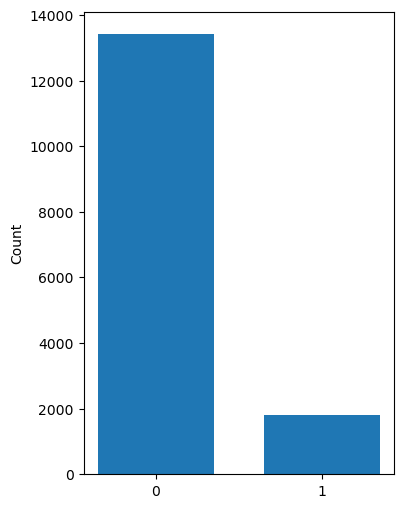

In [22]:
df_target = df[['AGREEMENT_RK', 'TARGET']].groupby('TARGET').count().reset_index()
plt.figure(figsize=(4, 6))
plt.bar(['1' if val==1 else '0' for val in df_target['TARGET'].values], 
                   df_target['AGREEMENT_RK'].values, width=0.7)
plt.ylabel('Count')
plt.savefig('data/Target.png', bbox_inches='tight')
plt.show()

Возраст клиентов

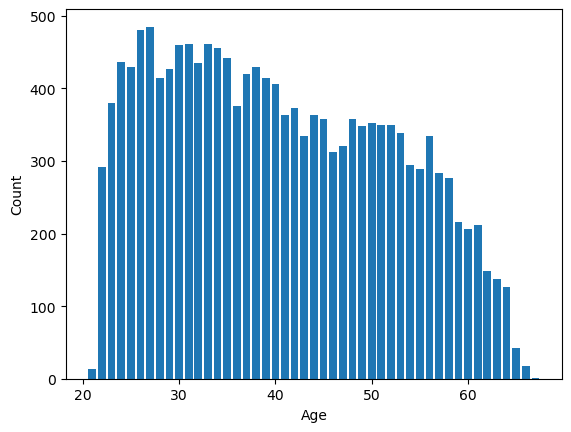

In [23]:
df_age = df[['AGREEMENT_RK', 'AGE']].groupby('AGE').count().reset_index()
plt.bar(df_age['AGE'].values, df_age['AGREEMENT_RK'].values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('data/Age.png', bbox_inches='tight')
plt.show()

Анализ категориальных признаков

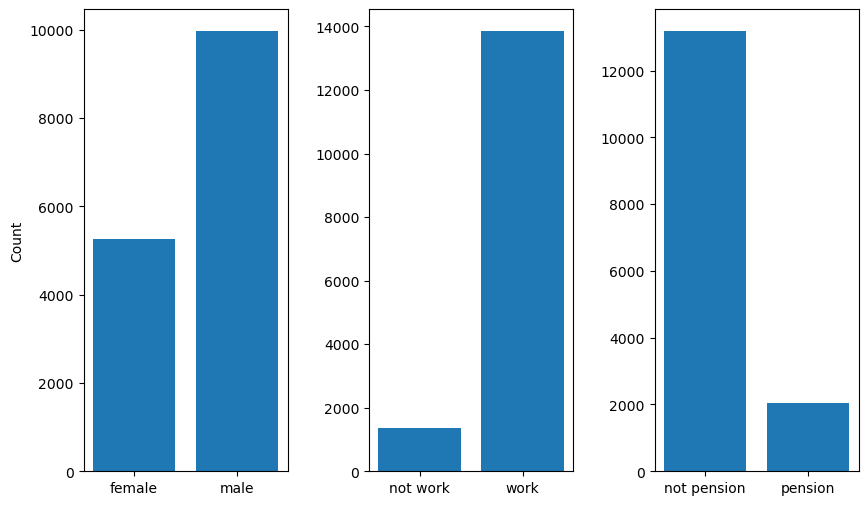

In [24]:
fig, (ax_gender, ax_status_work, ax_status_pension) = plt.subplots(1,3, figsize = (10,6))

df_gender = df[['AGREEMENT_RK', 'GENDER']].groupby('GENDER').count().reset_index()
ax_gender.bar(['male' if val==1 else 'female' for val in df_gender['GENDER'].values], 
                   df_gender['AGREEMENT_RK'].values)
ax_gender.set_ylabel('Count')
df_status_work = df[['AGREEMENT_RK', 'SOCSTATUS_WORK_FL']].groupby('SOCSTATUS_WORK_FL').count().reset_index()
ax_status_work.bar(['work' if val==1 else 'not work' for val in df_status_work['SOCSTATUS_WORK_FL'].values], 
                   df_status_work['AGREEMENT_RK'].values)
df_status_pension = df[['AGREEMENT_RK', 'SOCSTATUS_PENS_FL']].groupby('SOCSTATUS_PENS_FL').count().reset_index()
ax_status_pension.bar(['pension' if val==1 else 'not pension' for val in df_status_pension['SOCSTATUS_PENS_FL'].values], 
                      df_status_pension['AGREEMENT_RK'].values)
plt.sca(ax_status_pension)
plt.subplots_adjust(wspace=0.4)
plt.savefig('data/Categorical.png', bbox_inches='tight')
plt.show()

Зависимости числовых признаков

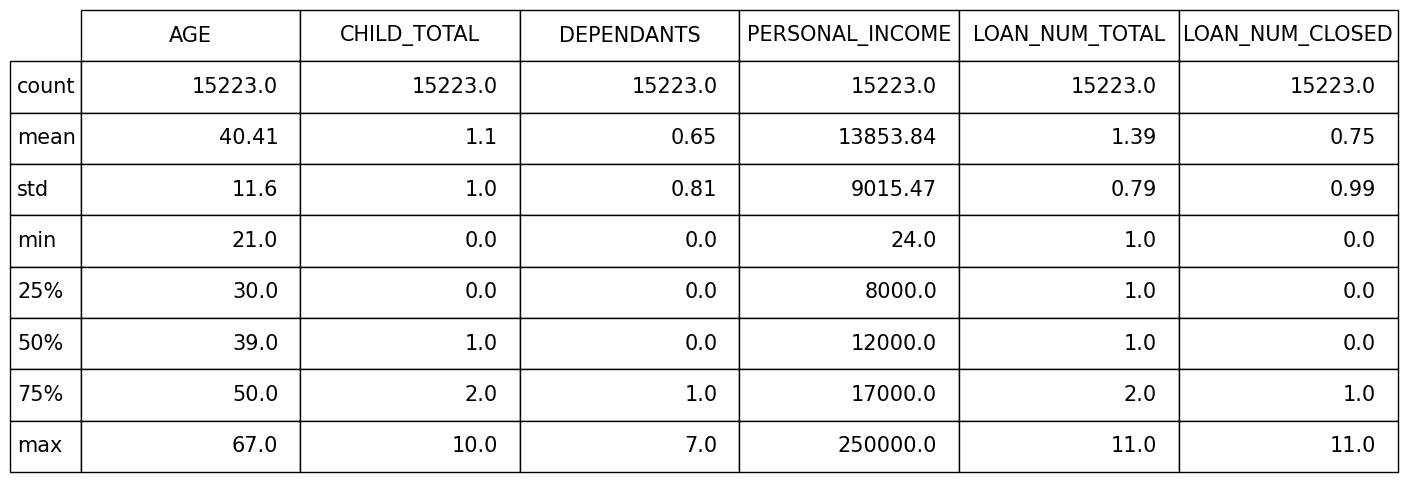

In [25]:
df_des = df.drop(['AGREEMENT_RK', 'GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'TARGET'], axis=1).describe()
fig, ax = plt.subplots(figsize = (17,6))
ax.axis('off')
bbox=[0, 0, 1, 1]
table = ax.table (cellText=df_des.round(2).values, rowLabels = df_des.index, colLabels=df_des.columns, loc='center', bbox=bbox)
table.auto_set_font_size(False)
table.set_fontsize(15)
plt.savefig('data/Numeric.png', bbox_inches='tight')
plt.show() 

Графики зависимостей целевой переменной и признаков

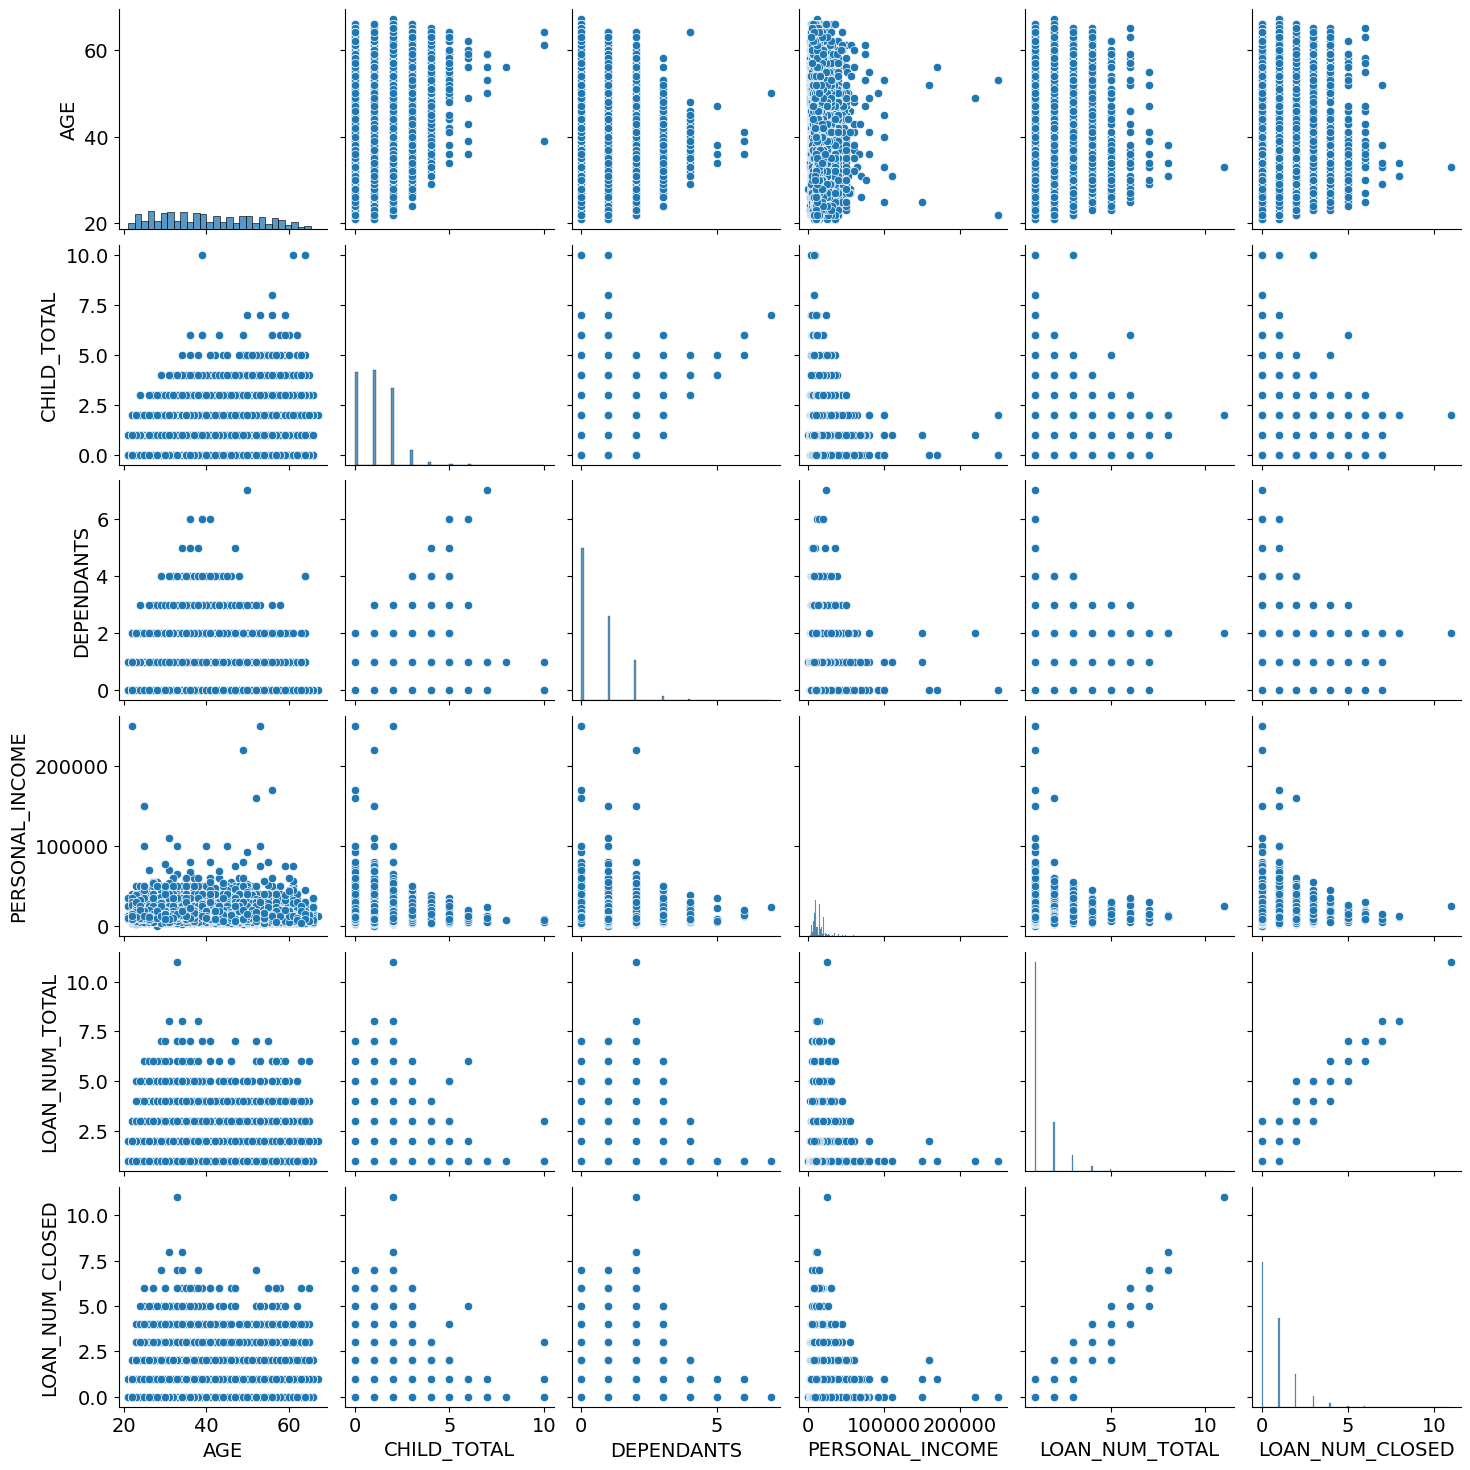

In [26]:
plt.rcParams.update({'font.size': 14})
g = sns.pairplot(df.drop(['AGREEMENT_RK', 'GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'TARGET'], axis=1))
plt.savefig('data/Numeric_depend.png', bbox_inches='tight')
plt.show()

Матрица корреляций

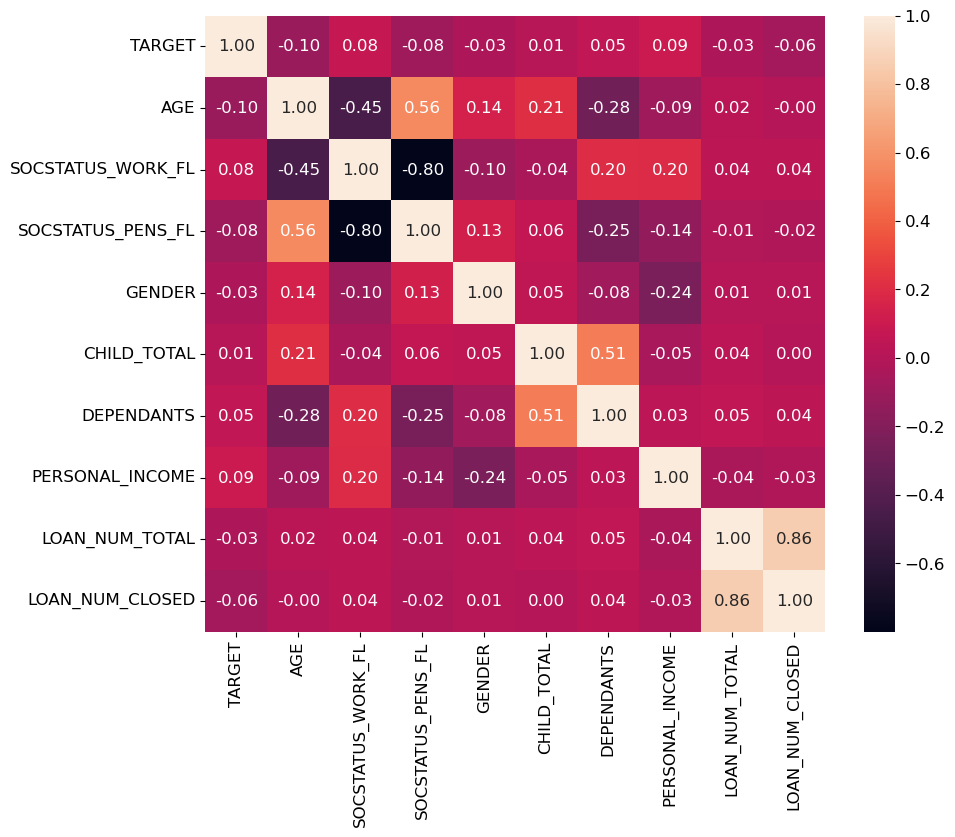

In [27]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize = (10,8))
sns.heatmap(df.drop('AGREEMENT_RK', axis=1).corr(), annot=True, fmt=".2f")
plt.savefig('data/Matrix_corr.png', bbox_inches='tight')
plt.show()